In this notebook, we will build an agent that acts as a restaurant waiter, capable of interacting with customers, answering their questions about the menu, and providing friendly responses. We will use the LangChain and LangGraph libraries to construct the agent's workflow and integrate it with OpenAI's GPT-based language models.

# Libraries, API Keys and Data

We need to install several libraries to build our agent:
*   langchain-community and langchain-openai: For language model integrations and prompts.
*   unstructured: For document loading and processing.
*   faiss-cpu: For vector similarity search.
*   langgraph: For constructing the workflow graph.

In [ ]:
!pip install -q langchain-community langchain-openai unstructured faiss-cpu langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.9 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/GenAI/RAG/Agentic RAG

/content/drive/MyDrive/GenAI/RAG/Agentic RAG


We import necessary modules from LangChain and LangGraph. Make sure your OpenAI API key is stored with the key 'genai_course' in Colab's user data.

In [ ]:
from google.colab import userdata
api_key = userdata.get('genai_course')

In [ ]:
from langchain_community.document_loaders import UnstructuredExcelLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.faiss import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.schema.output_parser import StrOutputParser

from typing import List
from typing_extensions import TypedDict
from IPython.display import display, Image

from langgraph.graph import StateGraph, END

We use UnstructuredExcelLoader to load data from the Excel file containing the restaurant menu. The mode="elements" parameter ensures the data is loaded as individual elements.

In [ ]:
# Specify the path to the Excel file containing the menu
file = 'dim sum montijo.xlsx'

# Create an instance of the loader with the specified mode
loader = UnstructuredExcelLoader(file, mode="elements")

# Load the data from the Excel file
data = loader.load()

We create embeddings for the menu data using OpenAIEmbeddings. FAISS is used to create a vector store from the documents, enabling efficient similarity search.



In [ ]:
# Initialize the embeddings model with the OpenAI API key
embeddings = OpenAIEmbeddings(openai_api_key=api_key)

# Create a vector store (FAISS) from the documents using the embeddings
db = FAISS.from_documents(data, embeddings)

# Process

We define a custom TypedDict class to keep track of the agent's state and implement functions representing different steps in the agent's workflow.

AgentState stores all the necessary information about the current state of the conversation.

In [ ]:
# Define a TypedDict to store the agent's state
class AgentState(TypedDict):
    start: bool             # Indicates if the conversation has started
    conversation: int       # Keeps track of conversation turns
    question: str           # Customer's question
    answer: str             # Agent's answer
    topic: bool             # Decision on whether the question is appropriate
    documents: list         # Relevant documents retrieved
    recursion_limit: int    # To avoid endless loops
    memory: list            # Conversation history

This function initiates the conversation by greeting the customer and capturing their initial question.

In [17]:
def greetings(state):
    # Greet the customer
    print("Hello! Welcome to the restaurant. I will be your waiter. How can I help you?")

    # Capture user input
    user_input = input()

    # Update the state with the customer's question and initialize conversation variables
    state['question'] = user_input
    state['conversation'] = 1
    state['memory'] = [user_input]

    return state

We need to assess if the customer's question is appropriate for a waiter to answer.

In [28]:
def check_question(state):
    # Get the customer's question from the state
    question = state['question']

    # Define the system prompt to evaluate the question's appropriateness
    system_prompt = """
    You are a grader evaluating the appropriateness of a customer's question or prompt to a waiter or waitress in a restaurant.
    Assess if the question is suitable to ask the restaurant staff and if the customer shows interest in continuing the conversation.
    Respond with "True" if the question is appropriate or on topic for the restaurant staff or indicates the customer is asking a question or giving you information.
    Otherwise respond with "False".
    Provide only "True" or "False" in your response.
    """

    # Create a prompt template for formatting
    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "User question: {question}"),
    ])

    # Format the prompt with the customer's question
    prompt = TEMPLATE.format(question=question)

    # Initialize the language model
    model = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

    # Invoke the model with the prompt
    response_text = model.invoke(prompt)

    # Update the state with the model's decision
    state['topic'] = response_text.content.strip()

    return state

This function routes the workflow based on whether the question is on-topic or off-topic.

In [29]:
# Function to check if the LLM model decides if the question is on topic on top
def topic_router(state):
  topic = state['topic']
  if topic == "True":
    return "on_topic"
  else:
    return "off_topic"

Provides an appropriate response if the customer's question is off-topic.

In [30]:
def off_topic_response(state):
    # Check if it's the first conversation turn
    if state['conversation'] <= 1:
        state['answer'] = "\nI apologize, I can't answer that question. I can only answer questions about the menu in this restaurant."
        print(state['answer'])
    else:
        state['answer'] = "\nHappy to help."
        print(state['answer'])

If the question is on-topic, we retrieve relevant documents and generate an answer using the language model.

**Retrieve Relevant Documents**
We use the conversation history to retrieve relevant menu items. similarity_search finds the most relevant documents.

In [31]:
def retrieve_docs(state):
    # Combine the conversation history into a single string
    memory = " ".join(state['memory'])

    # Retrieve the top 5 relevant documents based on similarity to the conversation history
    docs_faiss = db.similarity_search(memory, k=5)

    # Store the retrieved documents' content in the state
    state['documents'] = [doc.page_content for doc in docs_faiss]

    return state

In [39]:
# Build a function to generate the questions
def generate(state):
  # Initializing the model
  model = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

  # Extract the information
  question = state['question']
  documents = state['documents']
  memory = state['memory']

  # Define the system prompt for the model
  system_prompt = """
  You are a waiter at a restaurant tasked with answering the customer's question.
  Answer the question in the manner of a waiter, avoiding being too verbose.
  Do not include "waiter" or refer to yourself explicitly in your answer"""

  # Create a prompt template for formatting
  TEMPLATE = ChatPromptTemplate.from_messages([
      ("system", system_prompt),
      ("human", f"Context: {documents}\nConversation history so far: {memory}\nCustomer question: {question}")
  ])

  # Format the prompt
  prompt = TEMPLATE.format(documents = documents, memory = memory, question = question)

  # Invoke the model with the formatted prompt
  response_text = model.invoke(prompt)

  # Update the state with the model's response
  state['answer'] = response_text.content.strip()
  #print(state['answer'])

  return state

# Workflow

We use StateGraph to define the workflow of the agent, connecting the functions we've defined.

**Initialize StateGraph**
StateGraph helps in defining the flow of the agent's state across different functions.

In [40]:
# Initialize a StateGraph with the AgentState type
workflow = StateGraph(AgentState)


# Add the functions as nodes in the workflow
workflow.add_node("greetings", greetings)
workflow.add_node("check_question", check_question)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("generate", generate)

# Set the entry point of the workflow to the greetings function
workflow.set_entry_point("greetings")

# Add conditional edges based on the topic_router function's output
workflow.add_conditional_edges(
    "check_question",
    topic_router,
    {
        "on_topic": "retrieve_docs",
        "off_topic": "off_topic_response"
    }
)

# Define the sequence of steps in the workflow
workflow.add_edge("greetings", "check_question")
workflow.add_edge("retrieve_docs", "generate")

# Connect the off_topic_response node to the end of the workflow
workflow.add_edge("off_topic_response", END)

# Compile the workflow into an application
app = workflow.compile()

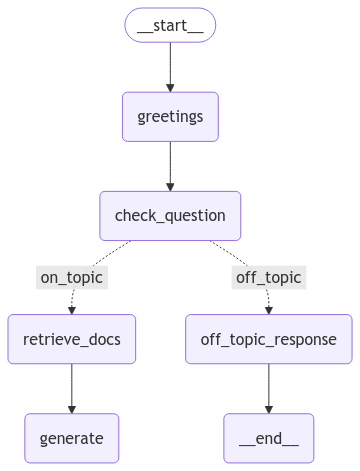

In [41]:
# Display the workflow graph for visualization
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [43]:
result = app.invoke({"start": True}, {'recursion_limit': 50})

Hello! Welcome to the restaurant. I will be your waiter. How can I help you?
I would like a soup
We have two delicious soup options: the Won Ton Soup with pork and shrimp for €3.95, and the Vegetarian Soup with bamboo, mushrooms, and vegetables, also for €3.95. Which one would you like?
